In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cdflib
import xarray

from scipy import stats,spatial
from datetime import date, time, datetime, timedelta

# Получение датасета из GIM-TEC

In [14]:
def build_tec_df_from_cdf(filename): 
    lats = [(87.5-i*2.5) for i in range(71)]
    longs = [180-j*5 for j in range(73)]
    idx = pd.MultiIndex.from_product([lats,longs])
    result = pd.DataFrame(index=idx)
    
    cdf_file = cdflib.CDF(filename)
    ionex_map = cdf_file.varget("tecUQR")
    for i in range(len(ionex_map)):
        result.insert(loc=i,column=i,value=np.concatenate(ionex_map[i],axis=0))
        
    return result

In [15]:
tec_df_6feb2023 = build_tec_df_from_cdf("gps_tec15min_igs_20230206_v01.cdf")
tec_df_6feb2023.head()

0          1          2          3     4          5     6   \
87.5 180  16.500000  16.500000  16.700001  17.400000  17.5  18.900000  18.9   
     175  16.600000  16.799999  16.900000  17.299999  17.4  18.799999  19.1   
     170  16.500000  16.500000  17.000000  17.200001  17.6  19.299999  20.5   
     165  16.400000  16.900000  17.100000  16.900000  19.0  19.400000  22.4   
     160  16.700001  16.600000  16.400000  17.400000  18.9  19.700001  24.4   

                 7     8          9   ...         86         87         88  \
87.5 180  19.500000  20.5  22.100000  ...  15.000000  16.299999  12.300000   
     175  19.900000  21.5  22.900000  ...  16.000000  16.900000  12.400000   
     170  22.000000  23.4  24.200001  ...  16.600000  17.500000  12.700000   
     165  24.299999  24.9  24.500000  ...  17.799999  20.200001  24.200001   
     160  25.400000  25.0  23.700001  ...  20.299999  21.000000  25.100000   

                 89    90         91         92    93    94         95  
87.5 180  14.500000  14.6  20.700001  21.299999  12.8  14.0  17.500000  
     175  14.600000  15.1  21.500000  12.200000  13.7  14.4  17.600000  
     170  15.300000  16.5  12.300000  13.200000  13.7  14.7  17.799999  
     165  16.799999  11.4  12.000000  12.700000  13.7  14.6  18.900000  
     160  12.400000  11.0  11.900000  12.700000  13.6  14.8  19.900000  

[5 rows x 96 columns]

# Получение оценки для фиксированной точки

In [16]:
# point = (latitude,longitude), tec_df - gim-tec dataframe

def calculate_tec_series(point,tec_df):
    if point in tec_df.index:
        return tec_df.loc[point,:]
    tree = spatial.KDTree(list(tec_df.index))
    dist, index = tree.query(point,k=4)
    dist_sum = sum(1/dist)
    
    return round(tec_df.iloc[index,:].mul(1/dist,axis=0).sum()/dist_sum,3)

In [17]:
calculate_tec_series(point=(50,50),tec_df=tec_df_6feb2023)

0     15.3
1     15.8
2     14.8
3     13.5
4     13.3
      ... 
91    11.1
92    10.1
93     8.5
94     8.5
95     8.6
Name: (50.0, 50), Length: 96, dtype: float32

# Получение временного ряда TEC по данным со станции

In [22]:
# stationd_df - dataframe with TEC data from a fixed point
# date - date in datetime.date format
# left - left border for time series, in days
# right - right border for time series, in days

def build_earthquake_series(station_df,date,left,right):
    start_date = (date-timedelta(days=left+10))
    end_date = (date+timedelta(days=right+10))
    
    ans = station_df[(station_df['date'].dt.date >= start_date) & (station_df['date'].dt.date <= end_date)].reset_index(drop=True)
    if len(ans) == 0:
        return None

    ans['relative_date'] = ans['date'].apply(lambda x: x.date() - date).dt.days
    ans.loc[:,'median'] = ans.groupby(['hour','min'])['tec'].transform(lambda x: x.rolling(21,11,center=True).median())
    ans.loc[:,'iqr'] = ans.groupby(['hour','min'])['tec'].transform(lambda x: x.rolling(21,11,center=True).apply(lambda x: stats.iqr(pd.Series(x))))
    ans['lower_bound'] = ans['median']-1.6*ans['iqr']
    ans['upper_bound'] = ans['median']+1.6*ans['iqr']
    
    ans = ans[(ans['date'].dt.date >= start_date+timedelta(days=10)) & (ans['date'].dt.date <= end_date-timedelta(days=10))].reset_index(drop=True)
    
    return ans[['station','datetime','date','relative_date','hour','min','tec','lower_bound','median','upper_bound']]

In [23]:
mers = pd.read_csv("output/stations/mers.csv",parse_dates=['date','datetime'])
mers.head()

,station,datetime,date,hour,min,tec
0,mers,1998-01-15 00:00:00,1998-01-15,0,0,6.7590
1,mers,1998-01-15 00:15:00,1998-01-15,0,15,6.9273
2,mers,1998-01-15 00:30:00,1998-01-15,0,30,6.7394
3,mers,1998-01-15 00:45:00,1998-01-15,0,45,6.9126
4,mers,1998-01-15 01:00:00,1998-01-15,1,0,6.1186


In [24]:
eq_6feb2023 = build_earthquake_series(station_df=mers,date=date(2023,2,6),left=10,right=5)

In [25]:
eq_6feb2023.head()

,station,datetime,date,relative_date,hour,min,tec,lower_bound,median,upper_bound
0,mers,2023-01-27 00:00:00,2023-01-27,-10,0,0,11.8245,9.21178,13.3857,17.55962
1,mers,2023-01-27 00:15:00,2023-01-27,-10,0,15,12.5732,9.11056,13.3960,17.68144
2,mers,2023-01-27 00:30:00,2023-01-27,-10,0,30,12.0955,9.63654,12.9607,16.28486
3,mers,2023-01-27 00:45:00,2023-01-27,-10,0,45,11.6488,9.34564,12.7514,16.15716
4,mers,2023-01-27 01:00:00,2023-01-27,-10,1,0,10.1800,7.82652,12.1902,16.55388


# Визуализация временного ряда TEC

In [26]:
def draw_tec_series(eq_series):
    fig, axes = plt.subplots(figsize=(12,6))
    plt.plot(eq_series['datetime'],eq_series['tec'],'k',label='TEC')
    plt.plot(eq_series['datetime'],eq_series['upper_bound'],'r',label='Верхняя граница')
    plt.plot(eq_series['datetime'],eq_series['lower_bound'],'m',label='Нижняя граница')
    axes.set_xticks(eq_series['date'].unique()[::2])
    axes.set_xticklabels(eq_series['relative_date'].unique()[::2])
    plt.xlabel("Дней до землетрясения")
    plt.ylabel("TEC")
    plt.legend()
    plt.show()

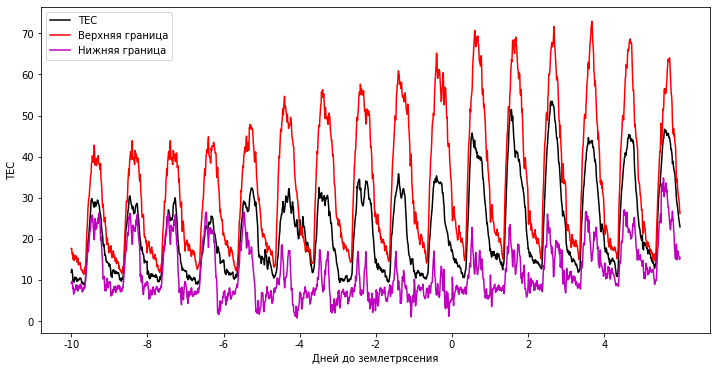

In [27]:
draw_tec_series(eq_6feb2023)

In [42]:
def draw_tec_heatmap(eq_series):
    eq_series['dev']=(eq_series['tec']-eq_series['median'])/eq_series['median']*100
    x = eq_series.pivot_table(columns=['relative_date'],index=['hour','min'],values='dev')
    eq_series = eq_series.drop('dev',axis=1)
    fig,axies = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(x)
    ax.set_yticklabels(labels=range(24),rotation=0)
    plt.xlabel("Дней до землетрясения")
    plt.ylabel("Час (UTC)")
    plt.show()

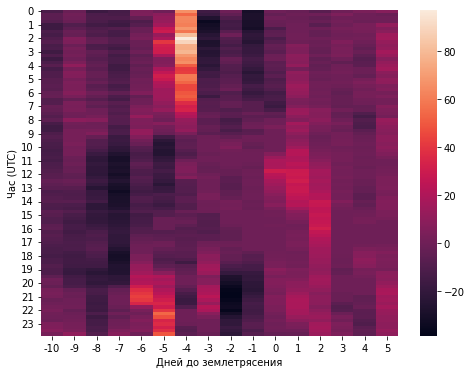

In [43]:
draw_tec_heatmap(eq_6feb2023)